In [28]:
import torch
from os import listdir
from os.path import join
import torch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, splev
import numpy as np

def group_data(list_of_dicts):
    n_dicts = len(list_of_dicts)
    result = dict()

    if n_dicts > 0:
        for k,v in list_of_dicts[0].items():
            if k != "singular":
                partial_result = []
                for d in list_of_dicts:
                        partial_result.append(torch.tensor(d[k]))
                all_metric_data = torch.stack(partial_result)
                mu = torch.mean(all_metric_data, dim=0)
                sigma = torch.std(all_metric_data, dim=0)
                result[k] = mu
                result[f"{k}_std"] = sigma
                    
        return result
    else:
        return None

def group_max_data(list_of_dicts):
    n_dicts = len(list_of_dicts)
    result = dict()

    if n_dicts > 0:
        for k,v in list_of_dicts[0].items():
            if k != "singular":
                partial_result = []
                for d in list_of_dicts:
                        partial_result.append(torch.tensor(d[k]))
                all_metric_data = torch.stack(partial_result)
                mu = torch.max(all_metric_data, dim=1)[0]
                sigma = torch.std(mu, dim=0)
                mu = mu.mean()
                result[k] = mu
                result[f"{k}_std"] = sigma
                    
        return result
    else:
        return None

def flatten_dict(dictionary):
    # task_env1 and eval
    result = dict()
    for k, v in dictionary['task_env1'].items():
        if len(v) > 0:
            result[k.replace("val","ac")] = v
    for k, v in dictionary['eval'].items():
        if len(v) > 0:
            result[k] = v
    return result
    
def get_data(files, method,dataset,spur):
    result = []
    for k, v in files.items():
        read_method = "_".join(k.split("_")[5:])

        if method == read_method and dataset in k and str(spur) in k:
            result.append(v)
    return result


def plot_metric(f_result, dataset, metric, methods,smooth=0):
    fig, ax = plt.subplots(1, len(spurs),figsize=(36, 3), constrained_layout=False,sharey="row")
    for i, spur in enumerate(spurs):
        for method in methods:
            y = f_result[method][dataset][spur][metric]
            x = list(range(len(y)))
            n = len(x)
            # Compute the B-spline representation of 1-D data
            tck = splrep(x, y, s=smooth)
            # Define new x values for the spline plot
            x_spline = torch.from_numpy(np.linspace(min(x), max(x), n))
            # Evaluate the spline at the new x values
            y_spline = torch.from_numpy(splev(x_spline, tck))
            std = f_result[method][dataset][spur][metric+"_std"]
            ax[i].plot(x_spline,y_spline,label=f"{method}")
            ax[i].fill_between(x, y_spline - std, y_spline + std, alpha=0.2)
            ax[i].legend()
            ax[i].set_title(f"Correlation: {spur}-{metric.capitalize()} vs iterations")


def create_table(results, datasets, methods):
    table_result =  {'method': [], 'dataset': [], 'spur': [], 'val_acc': [], 'val_worst_group_acc': []}
    # Create dictionary for pandas
    for method in methods:
        for dataset in datasets:
            for spur in spurs:
                table_result['method'].append(method)
                table_result['dataset'].append(dataset)
                table_result['spur'].append(spur)
                table_result['val_acc'].append(100*results[method][dataset][spur]['val_acc'].item())
                table_result['val_worst_group_acc'].append(100*results[method][dataset][spur]['val_worst_group_acc'].item())
    df = pd.DataFrame.from_dict(table_result)
    # Define a formatting function for the 'Salary' column
    def format_perc(perc):
        return '{:.2f}%'.format(perc)
    
    # Apply the formatting function to the 'Salary' column
    df['val_acc'] = df['val_acc'].apply(format_perc)
    df['val_worst_group_acc'] = df['val_worst_group_acc'].apply(format_perc)

    return df

In [18]:

results_folder = "stats" # Where to get stats from

def process_results(methods, datasets, results_folder=""):
    file_content = dict()
    # Get all datafiles
    for f in listdir(results_folder):
        a  = torch.load(join(results_folder,f))
        a = flatten_dict(a)
        file_content[f] = a
    
    # Group by method-dataset-correlation
    result = dict()
    for method in methods:
        result[method] = dict()
        for dataset in datasets:
            result[method][dataset] = dict()
            for spur in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
                data = get_data(file_content, method,dataset,spur)
                result[method][dataset][spur] = data
    
    # Get mean and stdevs of data
    f_result = dict()
    f_table_result = dict()
    for method in methods:
        f_result[method] = dict()
        f_table_result[method] = dict()
        for dataset in datasets:
            f_result[method][dataset] = dict()
            f_table_result[method][dataset] = dict()
            for spur in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
                f_result[method][dataset][spur] = group_data(result[method][dataset][spur])
                f_table_result[method][dataset][spur] = group_max_data(result[method][dataset][spur])
    return f_result, f_table_result

In [29]:
methods = ["svdrop_0.1"
          ]
datasets = ['mnistcifar']
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
all_results, all_table_results = process_results(methods, datasets, results_folder=results_folder)


## Load Results

In [30]:
baselines = create_table(all_table_results, datasets, methods)

In [31]:
baselines

method     dataset  spur val_acc val_worst_group_acc
0  svdrop_0.1  mnistcifar  0.00  94.30%              93.60%
1  svdrop_0.1  mnistcifar  0.25  94.53%              91.61%
2  svdrop_0.1  mnistcifar  0.50  93.17%              87.87%
3  svdrop_0.1  mnistcifar  0.75  89.90%              80.48%
4  svdrop_0.1  mnistcifar  0.90  79.70%              64.62%
5  svdrop_0.1  mnistcifar  1.00  69.00%              54.93%

In [27]:
all_table_results['svdrop_0.1']['mnistcifar'][0.0]

{'train_acc': tensor([1., 1., 1.]),
 'train_acc_std': tensor(0.),
 'train_loss': tensor([0.7472, 0.6988, 0.6925]),
 'train_loss_std': tensor(0.0299),
 'train_worst_group_loss': tensor([1.3537, 1.4145, 0.9805]),
 'train_worst_group_loss_std': tensor(0.2350),
 'train_worst_group_acc': tensor([1., 1., 1.]),
 'train_worst_group_acc_std': tensor(0.),
 'train_best_group_loss': tensor([0.6917, 0.6814, 0.6920]),
 'train_best_group_loss_std': tensor(0.0060),
 'train_best_group_acc': tensor([1., 1., 1.]),
 'train_best_group_acc_std': tensor(0.),
 'ac_acc': tensor([0.9370, 0.9410, 0.9510]),
 'ac_acc_std': tensor(0.0072),
 'ac_loss': tensor([0.7646, 0.8982, 0.6998]),
 'ac_loss_std': tensor(0.1011),
 'ac_worst_group_loss': tensor([1.4054, 1.8776, 0.9953]),
 'ac_worst_group_loss_std': tensor(0.4415),
 'ac_worst_group_acc': tensor([0.9297, 0.9336, 0.9447]),
 'ac_worst_group_acc_std': tensor(0.0078),
 'ac_best_group_loss': tensor([0.6920, 0.6823, 0.6917]),
 'ac_best_group_loss_std': tensor(0.0055),
 '

In [33]:
methods = [
          "rw","imgnet_FT", "erm","gdro",
          "erm_ft_10","erm_ft_50","erm_ft_100","erm_ft_200","erm_ft_500","erm_ft_1000",
          "svdrop_0.0","svdrop_0.1","svdrop_0.2","svdrop_0.3","svdrop_0.4","svdrop_0.5",
           "svdrop_0.6","svdrop_0.7","svdrop_0.8","svdrop_0.9","svdrop_1.0"
          ]
datasets = ['mnistcifar']
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
all_results, all_table_results = process_results(methods, datasets, results_folder=results_folder)
baselines = create_table(all_table_results, datasets, methods)

## Methods vs each other

### Baselines: ERM, RW, GDRO, IMGNET_ERM

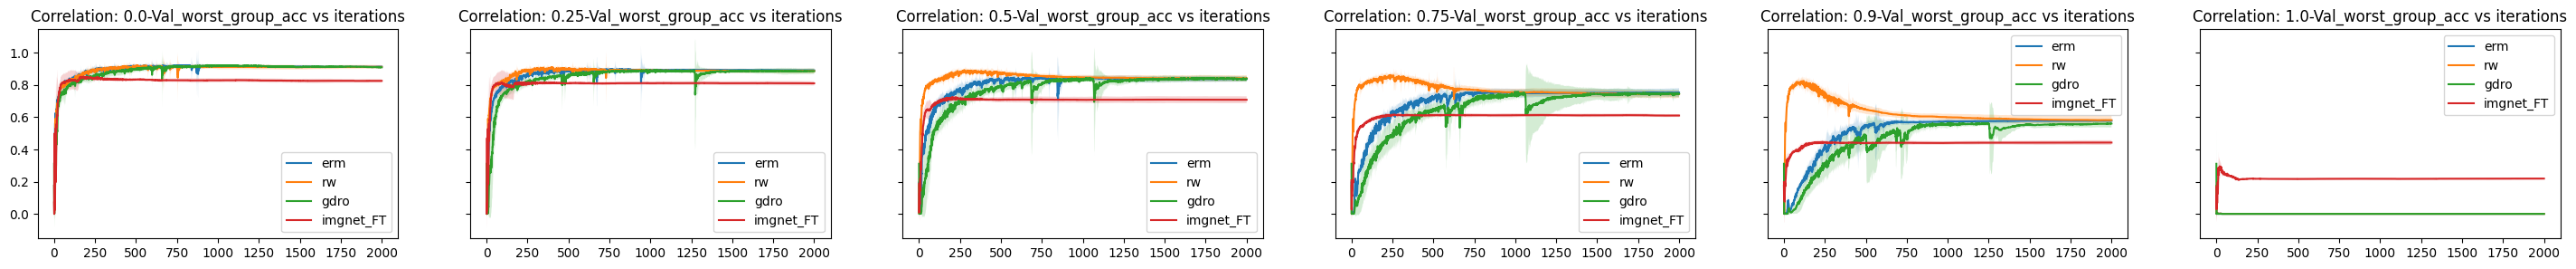

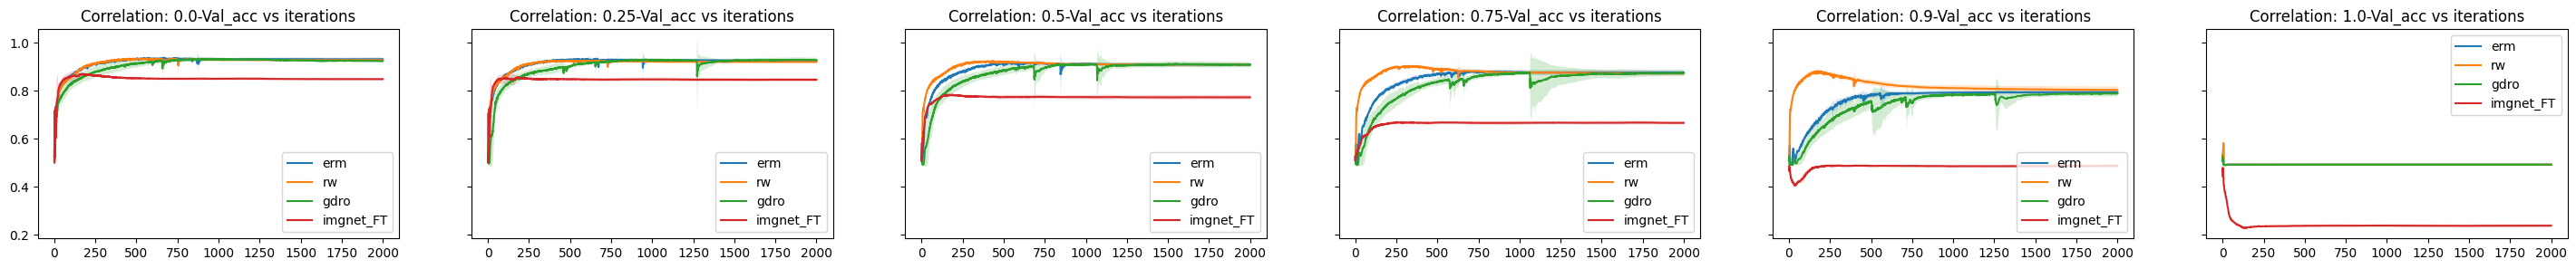

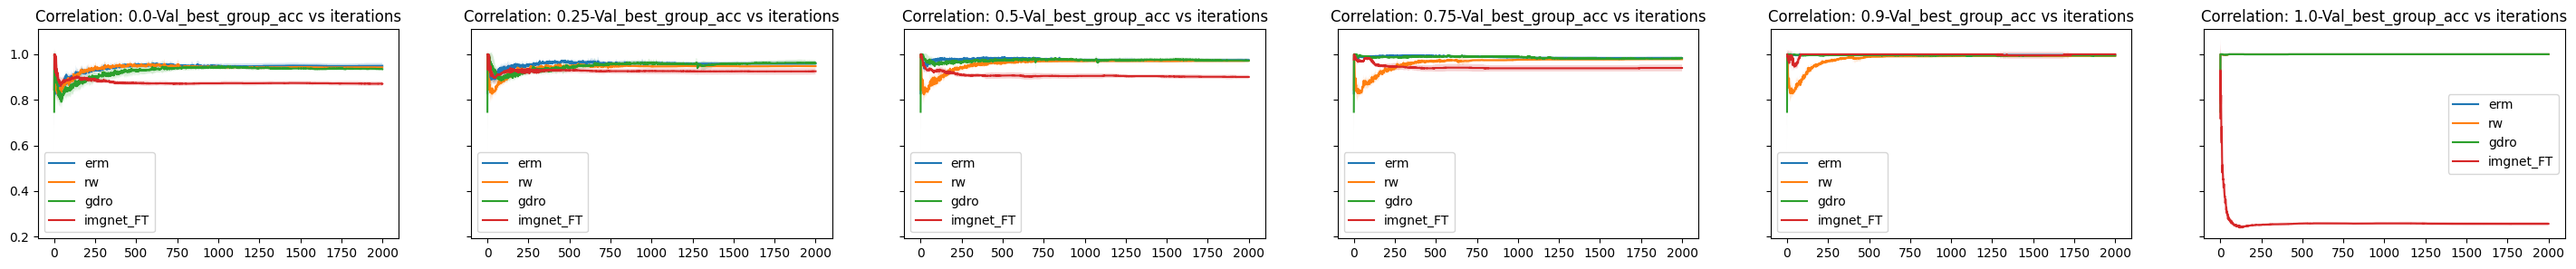

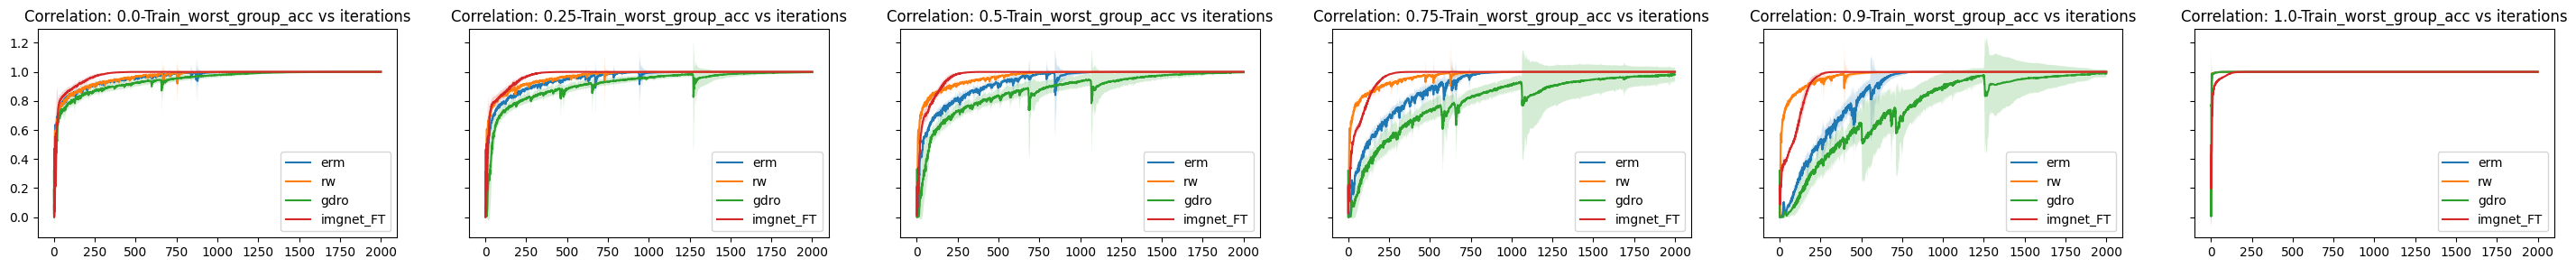

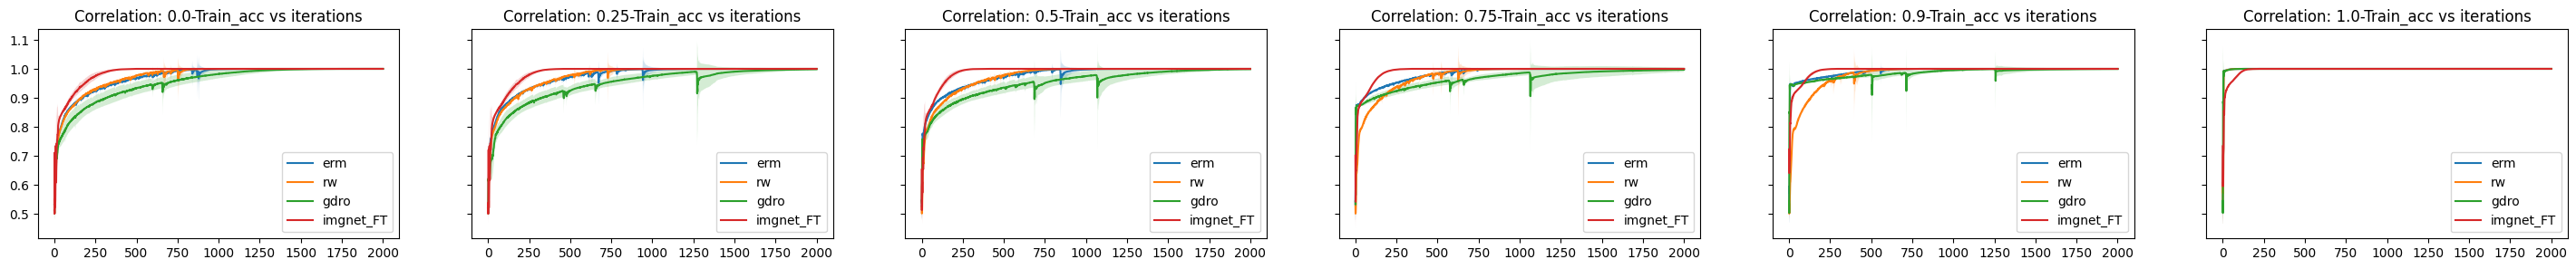

In [34]:
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
methods = ['erm','rw','gdro','imgnet_FT']
metrics = ['val_worst_group_acc','val_acc','val_best_group_acc','train_worst_group_acc','train_acc']
for metric in metrics:
    plot_metric(all_results, "mnistcifar", metric, methods)

### DFR

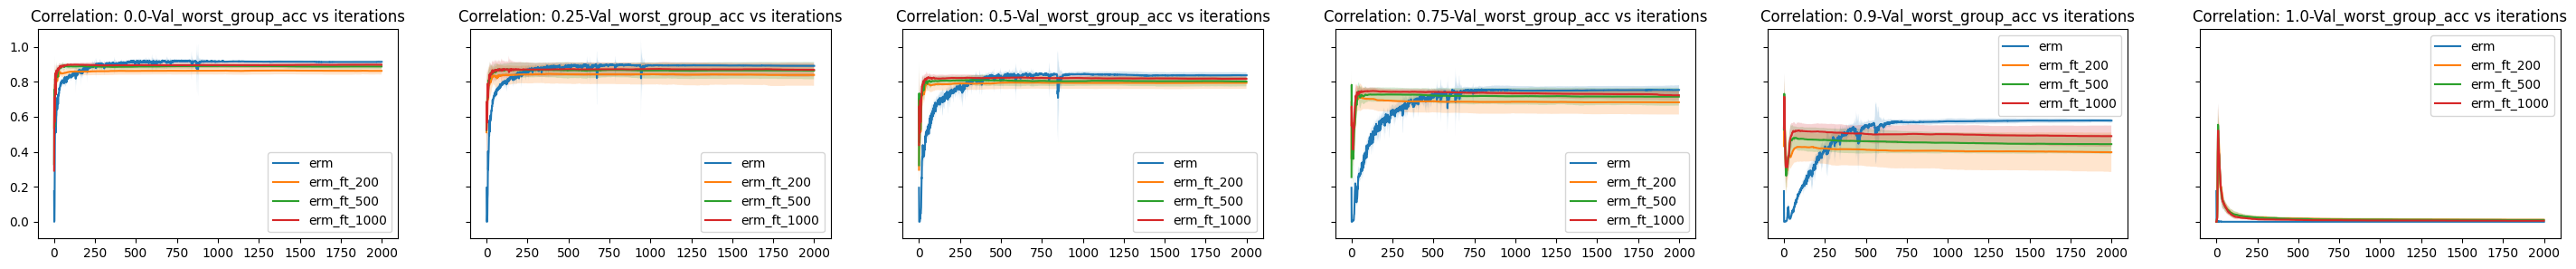

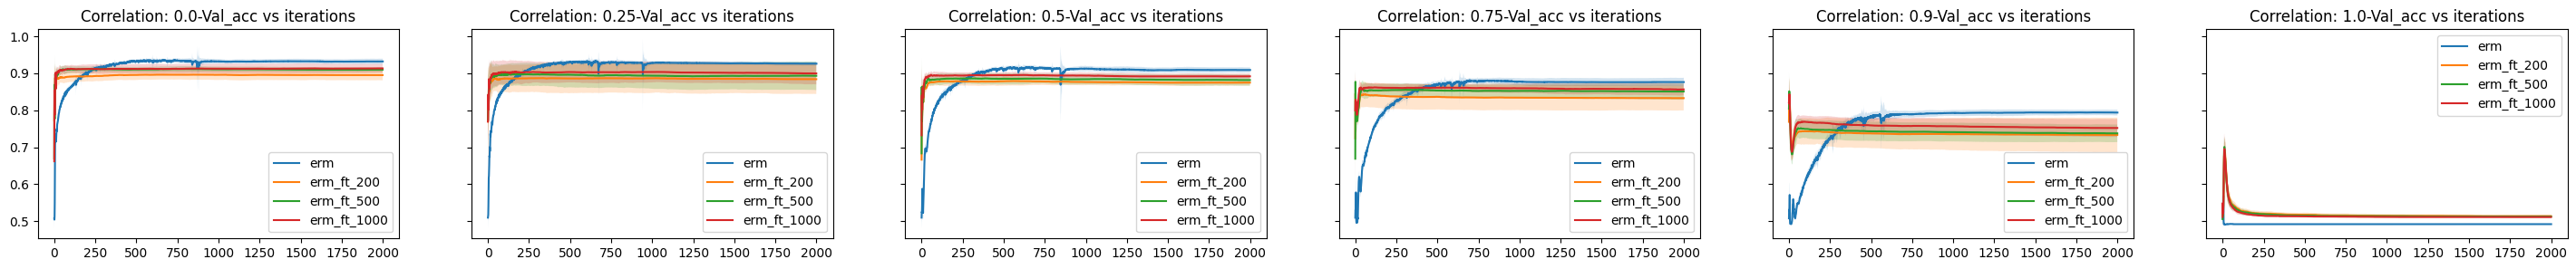

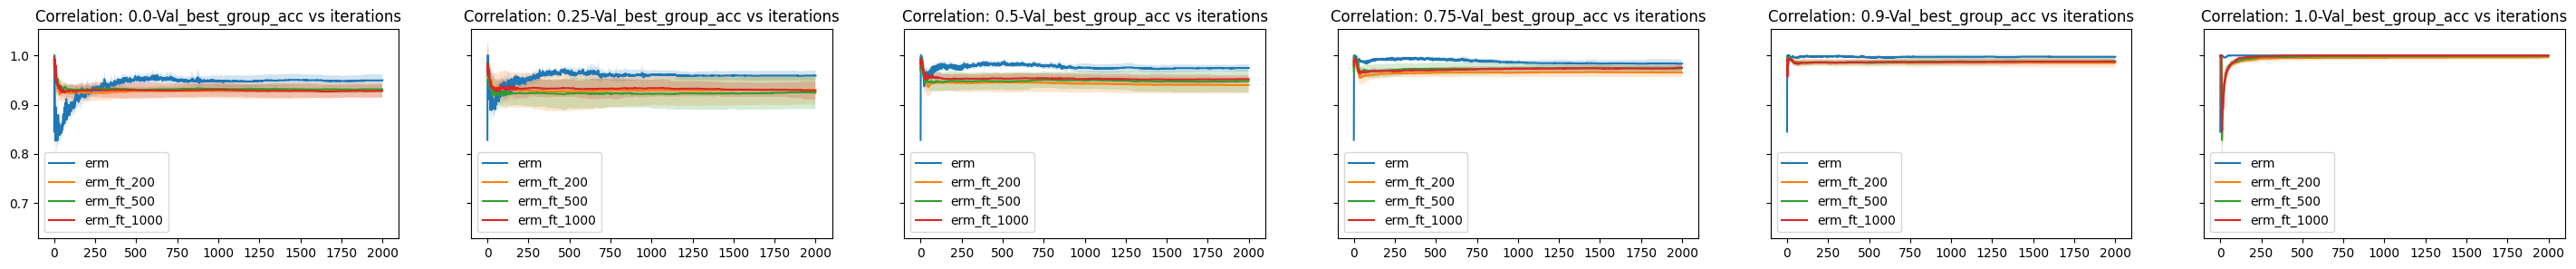

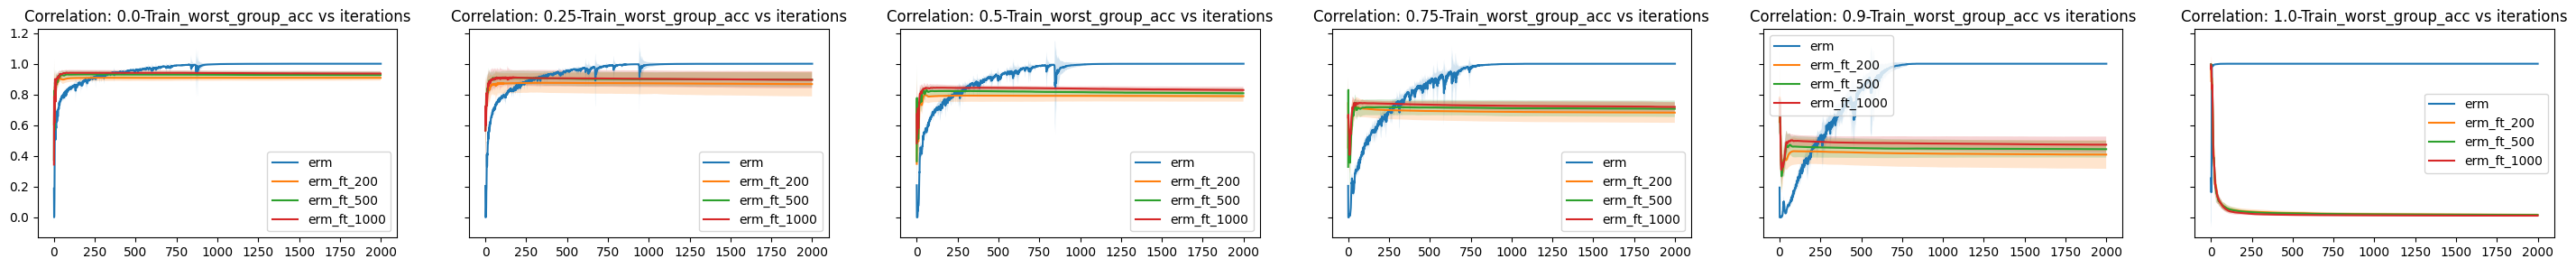

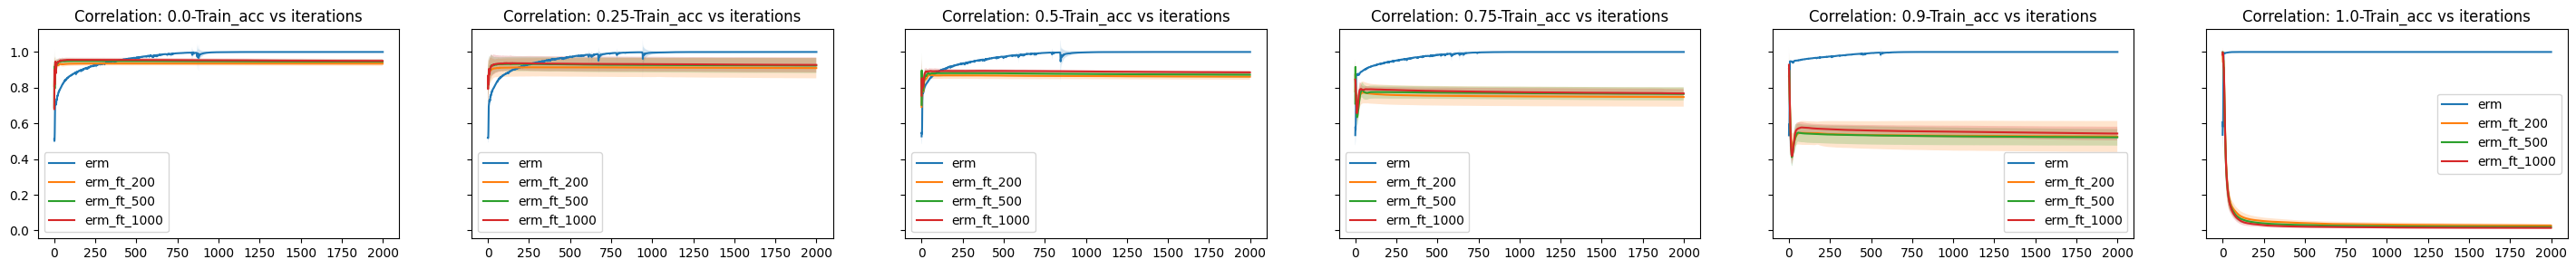

In [35]:
methods = ['erm',"erm_ft_200","erm_ft_500","erm_ft_1000"]
metrics = ['val_worst_group_acc','val_acc','val_best_group_acc','train_worst_group_acc','train_acc']
for metric in metrics:
    plot_metric(all_results, "mnistcifar", metric, methods)

### SVDROP

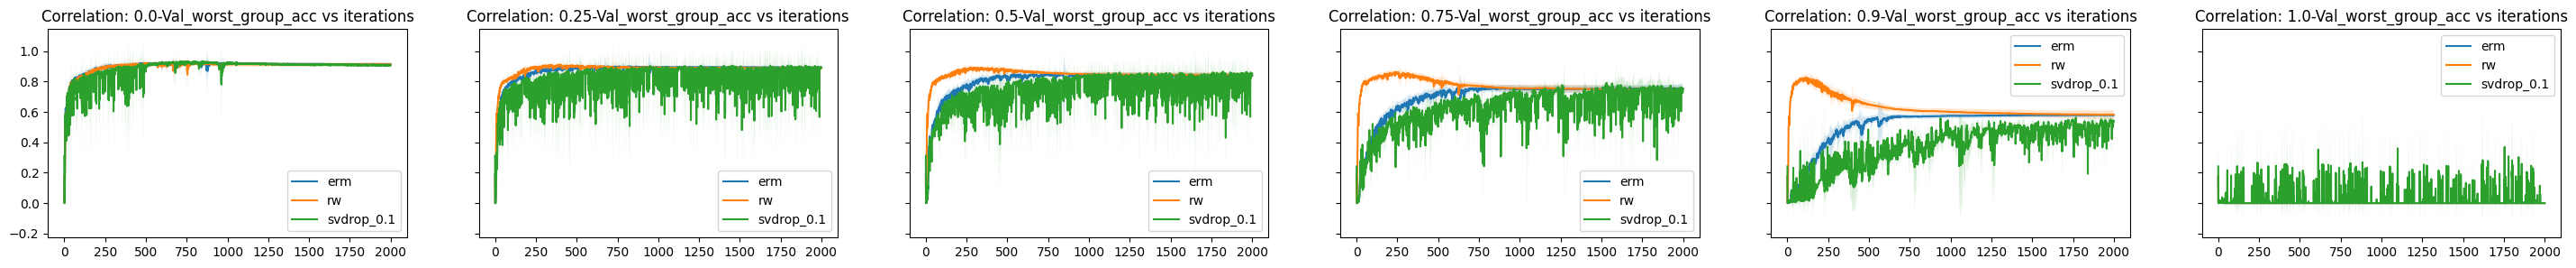

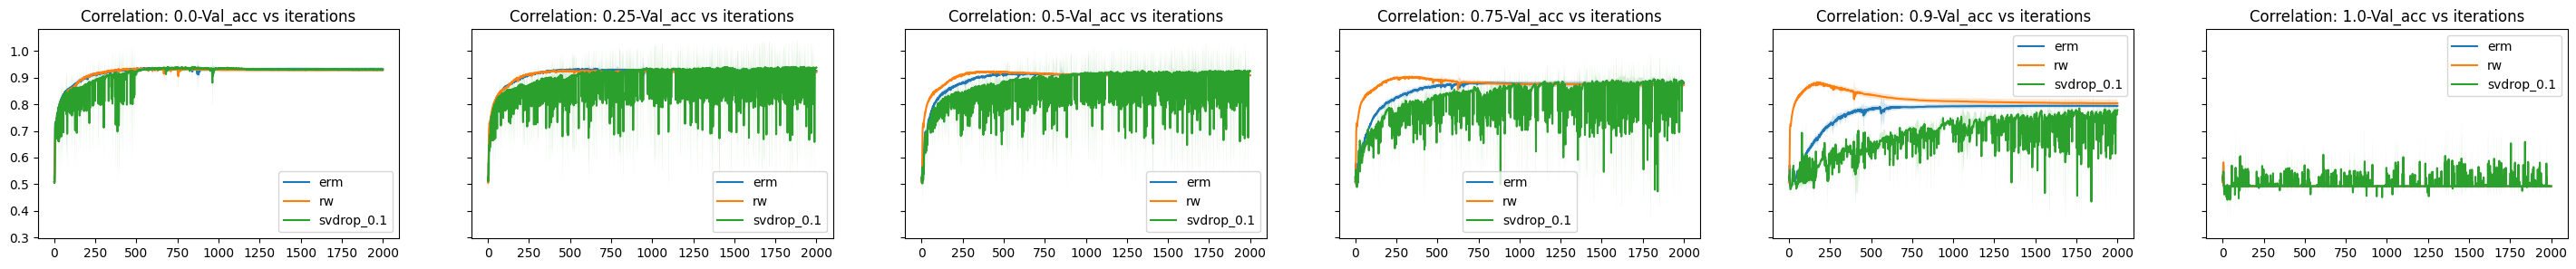

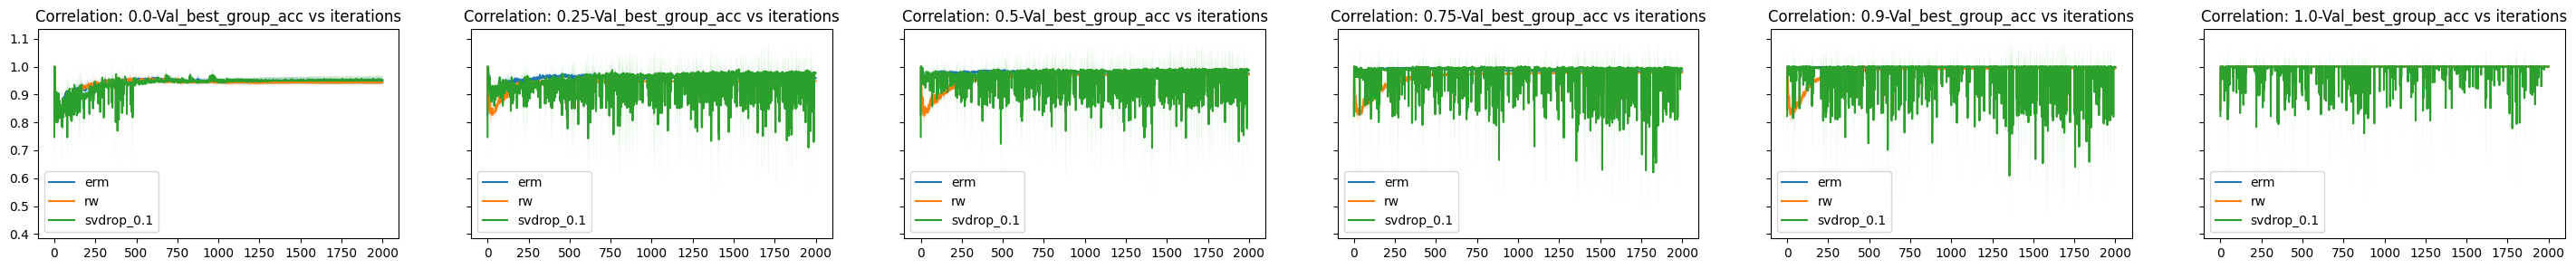

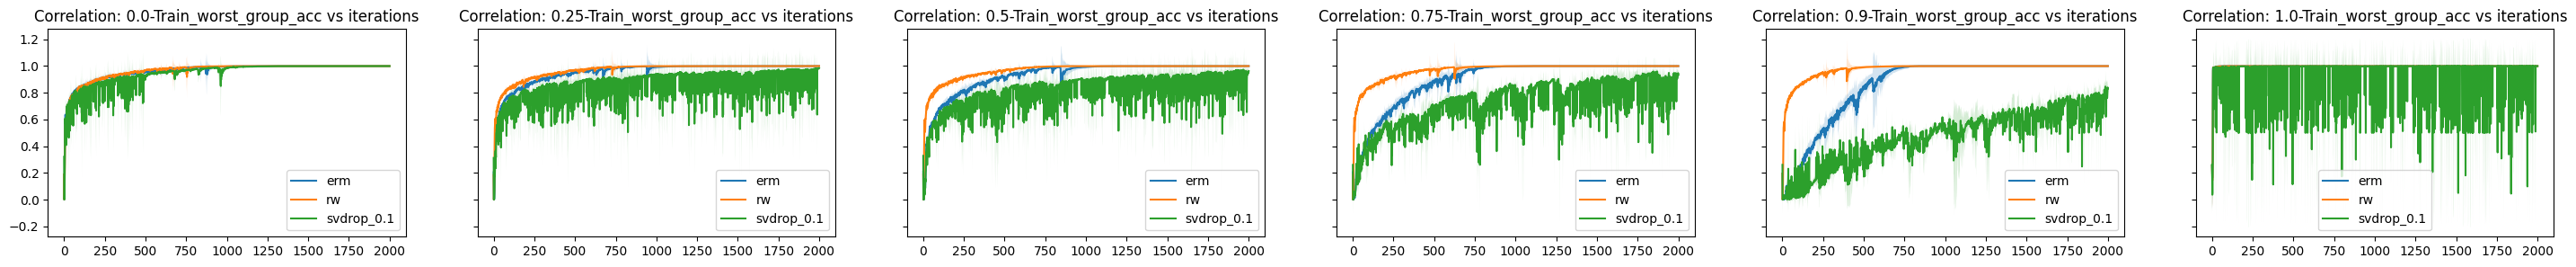

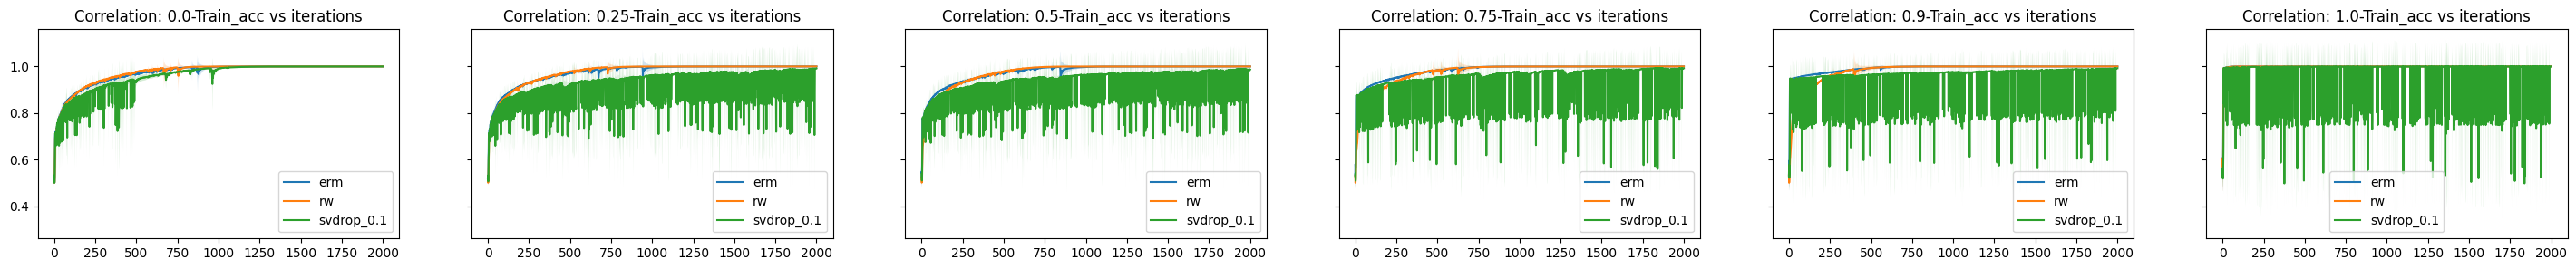

In [36]:
methods = ["erm", "rw","svdrop_0.1"]
metrics = ['val_worst_group_acc','val_acc','val_best_group_acc','train_worst_group_acc','train_acc']
for metric in metrics:
    plot_metric(all_results, "mnistcifar", metric, methods,smooth=0)

# Results Table

## Imagenet pretraining: does it help against Spurious Correlations?

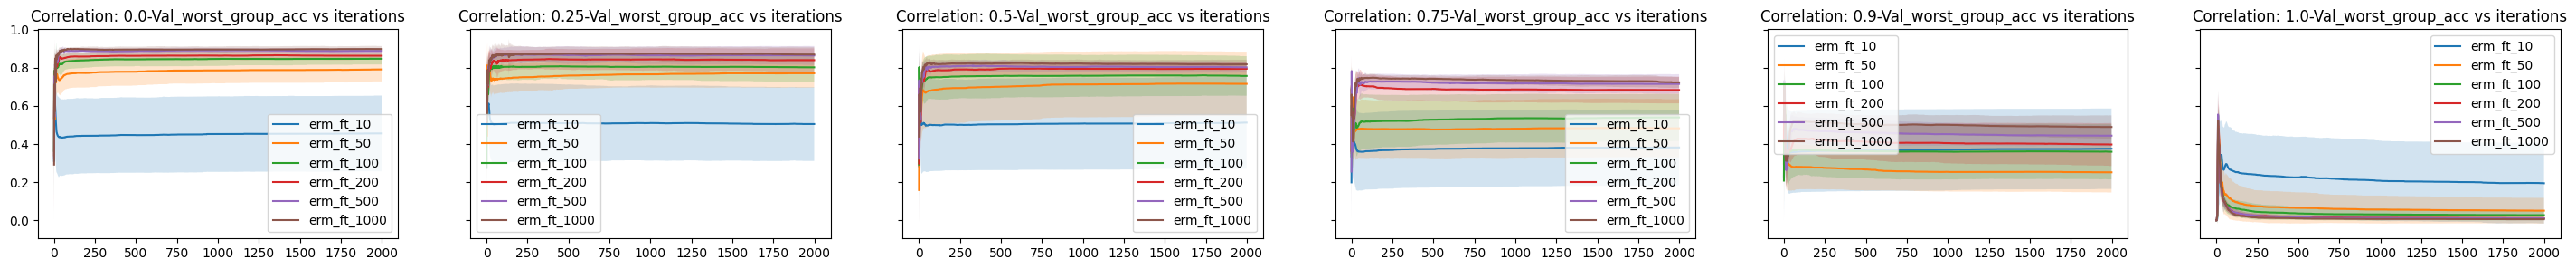

In [46]:
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
plot_metric(results, "mnistcifar", 'val_worst_group_acc')

In [58]:
dfr.groupby(['dataset','spur'])['val_worst_group_acc'].max().reset_index()

dataset  spur val_worst_group_acc
0  mnistcifar  0.00              89.88%
1  mnistcifar  0.25              87.37%
2  mnistcifar  0.50              82.65%
3  mnistcifar  0.75              78.25%
4  mnistcifar  0.90              73.12%
5  mnistcifar  1.00              55.45%

In [68]:
indices = df.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()
dfr = df.loc[indices]

In [92]:
total = baselines._append(dfr)
def requires_train_labels(method):
    if method in ['gdro','rw']:
        return True
    return False

def requires_test_labels(method):
    if "erm_ft" in method:
        return True
    elif method == "jtt":
        return True
    else:
        return False
total['Labels_in_Train'] = total['method'].apply(requires_train_labels)
total['Labels_in_Test'] = total['method'].apply(requires_test_labels)

In [83]:
total

method     dataset  spur val_acc val_worst_group_acc  \
0            rw  mnistcifar  0.00  93.51%              92.21%   
1            rw  mnistcifar  0.25  92.67%              91.04%   
2            rw  mnistcifar  0.50  92.39%              89.18%   
3            rw  mnistcifar  0.75  90.38%              86.17%   
4            rw  mnistcifar  0.90  88.25%              82.56%   
5            rw  mnistcifar  1.00  58.19%               0.39%   
6     imgnet_FT  mnistcifar  0.00  87.08%              85.19%   
7     imgnet_FT  mnistcifar  0.25  85.69%              81.70%   
8     imgnet_FT  mnistcifar  0.50  78.36%              72.46%   
9     imgnet_FT  mnistcifar  0.75  66.89%              61.60%   
10    imgnet_FT  mnistcifar  0.90  48.81%              44.67%   
11    imgnet_FT  mnistcifar  1.00  47.92%              29.59%   
12       svdrop  mnistcifar  0.00  93.00%              92.03%   
13       svdrop  mnistcifar  0.25  73.07%              58.76%   
14       svdrop  mnistcifar  0.50  72.13%              52.97%   
15       svdrop  mnistcifar  0.75  68.47%              52.87%   
16       svdrop  mnistcifar  0.90  66.77%              51.88%   
17       svdrop  mnistcifar  1.00  62.23%              53.75%   
18          erm  mnistcifar  0.00  93.57%              92.22%   
19          erm  mnistcifar  0.25  93.37%              90.06%   
20          erm  mnistcifar  0.50  91.67%              84.92%   
21          erm  mnistcifar  0.75  88.10%              75.69%   
22          erm  mnistcifar  0.90  79.44%              57.89%   
23          erm  mnistcifar  1.00  56.87%               0.36%   
24         gdro  mnistcifar  0.00  93.30%              92.38%   
25         gdro  mnistcifar  0.25  92.98%              89.48%   
26         gdro  mnistcifar  0.50  91.22%              84.47%   
27         gdro  mnistcifar  0.75  87.73%              75.83%   
28         gdro  mnistcifar  0.90  78.92%              56.50%   
29         gdro  mnistcifar  1.00  51.40%               0.33%   
30  erm_ft_1000  mnistcifar  0.00  91.32%              89.88%   
31  erm_ft_1000  mnistcifar  0.25  90.37%              87.37%   
32  erm_ft_1000  mnistcifar  0.50  89.60%              82.65%   
27   erm_ft_500  mnistcifar  0.75  87.71%              78.25%   
28   erm_ft_500  mnistcifar  0.90  85.14%              73.12%   
29   erm_ft_500  mnistcifar  1.00  70.11%              55.45%   

    Labels_in_Train  Labels_in_Test  
0              True           False  
1              True           False  
2              True           False  
3              True           False  
4              True           False  
5              True           False  
6             False           False  
7             False           False  
8             False           False  
9             False           False  
10            False           False  
11            False           False  
12            False           False  
13            False           False  
14            False           False  
15            False           False  
16            False           False  
17            False           False  
18            False           False  
19            False           False  
20            False           False  
21            False           False  
22            False           False  
23            False           False  
24             True           False  
25             True           False  
26             True           False  
27             True           False  
28             True           False  
29             True           False  
30            False            True  
31            False            True  
32            False            True  
27            False            True  
28            False            True  
29            False            True

### Final Results

In [96]:
total.loc[total.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()].sort_values(by="Labels_in_Train") # Overall

method     dataset  spur val_acc val_worst_group_acc  Labels_in_Train  \
24  erm_ft_500  mnistcifar  0.00  91.17%              89.26%            False   
1    erm_ft_10  mnistcifar  0.25  82.96%              67.02%            False   
2    erm_ft_10  mnistcifar  0.50  83.47%              63.52%            False   
3    erm_ft_10  mnistcifar  0.75  81.32%              60.24%            False   
4    erm_ft_10  mnistcifar  0.90  79.16%              58.91%            False   
29  erm_ft_500  mnistcifar  1.00  70.11%              55.45%            False   
24        gdro  mnistcifar  0.00  93.30%              92.38%             True   
1           rw  mnistcifar  0.25  92.67%              91.04%             True   
2           rw  mnistcifar  0.50  92.39%              89.18%             True   
3           rw  mnistcifar  0.75  90.38%              86.17%             True   
4           rw  mnistcifar  0.90  88.25%              82.56%             True   
29        gdro  mnistcifar  1.00  51.40%               0.33%             True   

    Labels_in_Test  
24            True  
1             True  
2             True  
3             True  
4             True  
29            True  
24           False  
1            False  
2            False  
3            False  
4            False  
29           False

In [38]:
# Sort within each group and get the first row
baselines.sort_values(by='val_worst_group_acc', ascending=False).groupby(['dataset', 'spur']).first().reset_index()

dataset  spur      method val_acc val_worst_group_acc
0  mnistcifar  0.00  svdrop_0.2  94.73%              94.10%
1  mnistcifar  0.25          rw  93.19%              92.14%
2  mnistcifar  0.50          rw  92.87%              90.54%
3  mnistcifar  0.75          rw  90.84%              87.56%
4  mnistcifar  0.90          rw  88.69%              84.82%
5  mnistcifar  1.00  svdrop_1.0  79.85%              71.86%

In [101]:
total.sort_values(by='val_worst_group_acc', ascending=False).groupby(['dataset', 'spur','Labels_in_Train']).first().reset_index().sort_values(by="Labels_in_Train")

dataset  spur  Labels_in_Train      method val_acc val_worst_group_acc  \
0   mnistcifar  0.00            False         erm  93.57%              92.22%   
2   mnistcifar  0.25            False         erm  93.37%              90.06%   
4   mnistcifar  0.50            False         erm  91.67%              84.92%   
6   mnistcifar  0.75            False  erm_ft_500  87.71%              78.25%   
8   mnistcifar  0.90            False  erm_ft_500  85.14%              73.12%   
10  mnistcifar  1.00            False  erm_ft_500  70.11%              55.45%   
1   mnistcifar  0.00             True        gdro  93.30%              92.38%   
3   mnistcifar  0.25             True          rw  92.67%              91.04%   
5   mnistcifar  0.50             True          rw  92.39%              89.18%   
7   mnistcifar  0.75             True          rw  90.38%              86.17%   
9   mnistcifar  0.90             True          rw  88.25%              82.56%   
11  mnistcifar  1.00             True          rw  58.19%               0.39%   

    Labels_in_Test  
0            False  
2            False  
4            False  
6             True  
8             True  
10            True  
1            False  
3            False  
5            False  
7            False  
9            False  
11           False

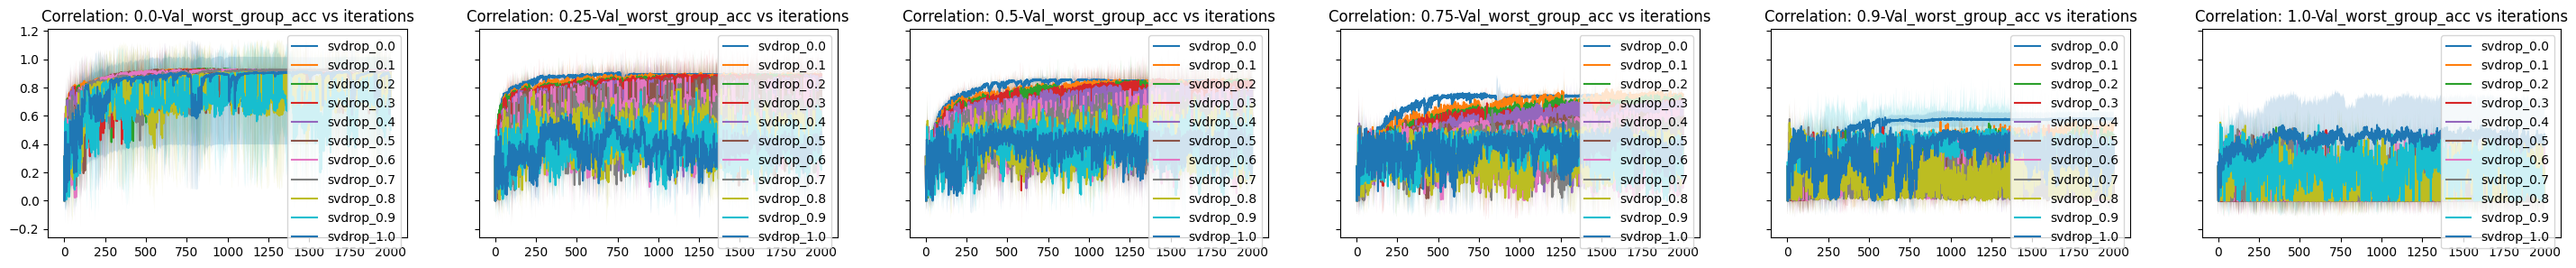

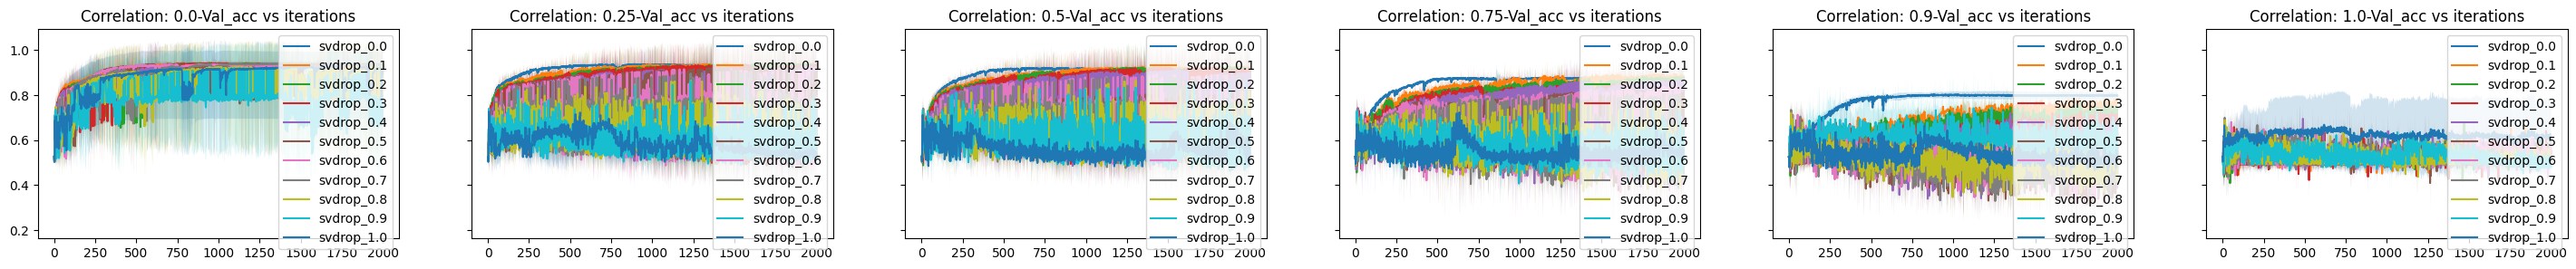

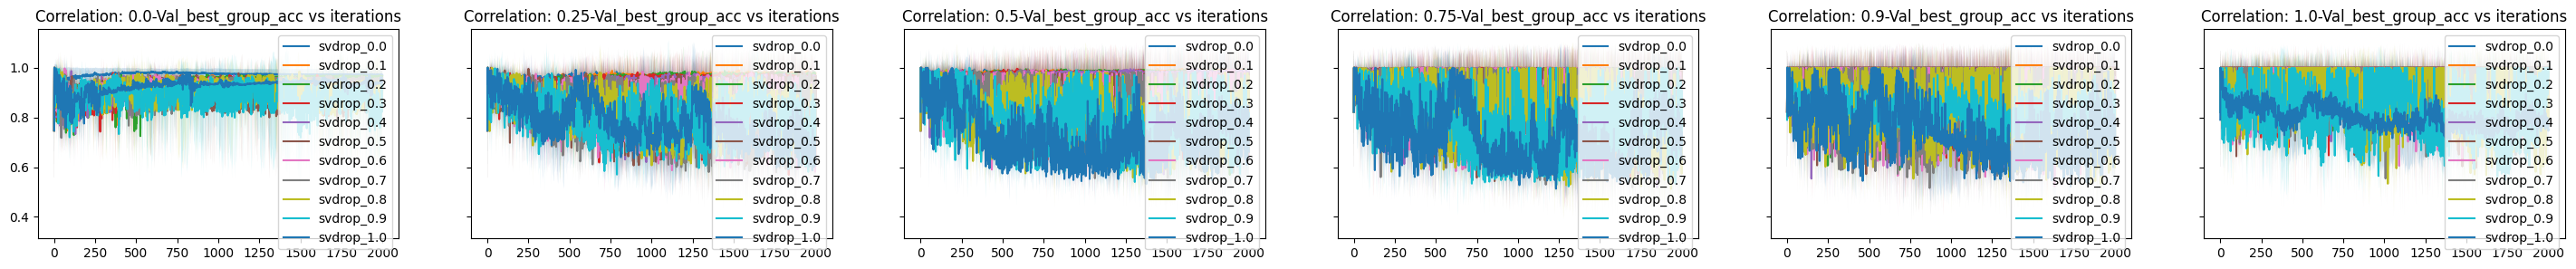

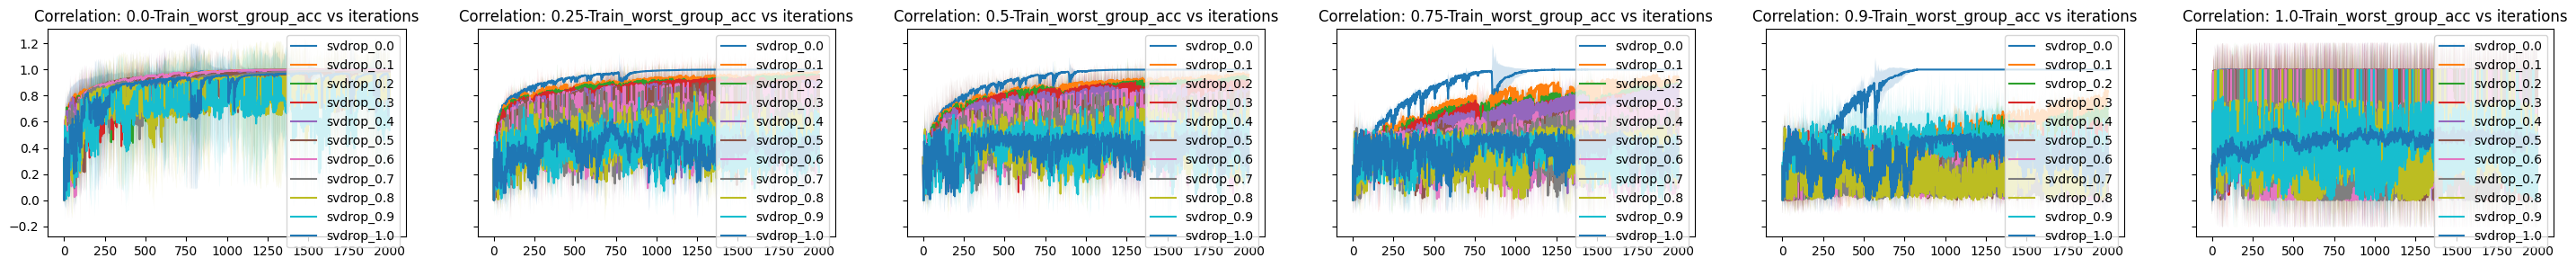

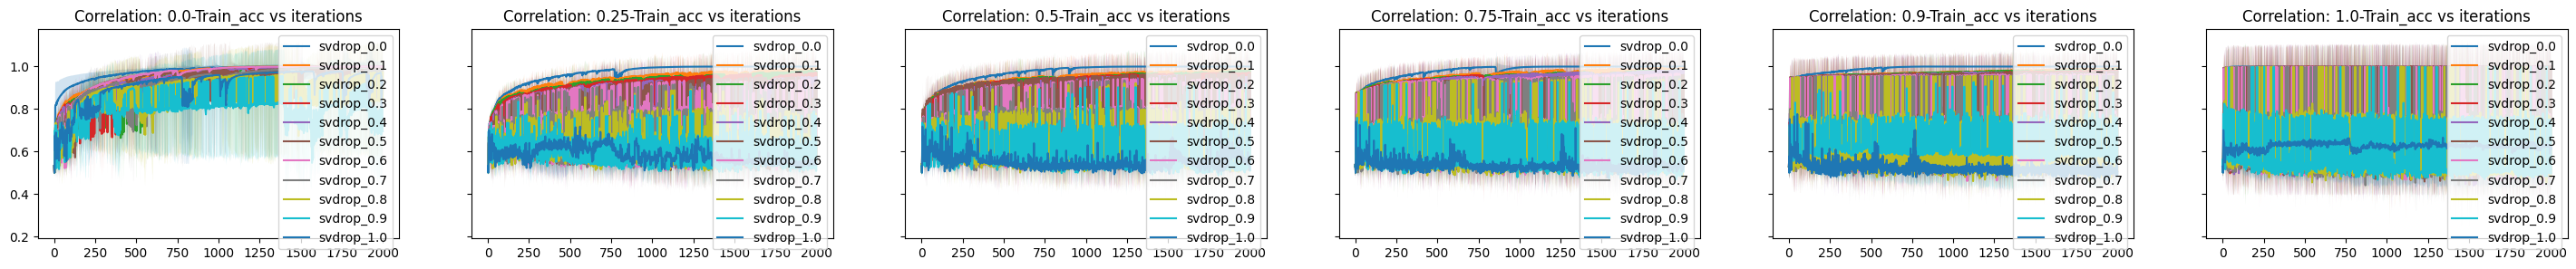

In [6]:
plot_metric(results, "mnistcifar", 'val_worst_group_acc')
plot_metric(results, "mnistcifar", 'val_acc')
plot_metric(results, "mnistcifar", 'val_best_group_acc')
plot_metric(results, "mnistcifar", 'train_worst_group_acc')
plot_metric(results, "mnistcifar", 'train_acc')

In [16]:
svdrop.groupby(['dataset','spur'])['val_worst_group_acc'].max().reset_index()

dataset  spur val_worst_group_acc
0  mnistcifar  0.00              93.53%
1  mnistcifar  0.25              90.89%
2  mnistcifar  0.50              86.52%
3  mnistcifar  0.75              79.08%
4  mnistcifar  0.90              58.99%
5  mnistcifar  1.00              55.34%

In [20]:
sv_max = svdrop.loc[svdrop.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()]
#print(sv_max.pivot(index="method",columns="spur",values=['val_worst_group_acc']))

In [13]:
pivot_df = svdrop.pivot(index='method', columns='spur', values=['val_acc','val_worst_group_acc'])
print(pivot_df)

           val_acc                                          \
spur          0.00    0.25    0.50    0.75    0.90    1.00   
method                                                       
svdrop_0.0  84.77%  93.80%  92.27%  87.70%  80.35%  59.05%   
svdrop_0.1  94.00%  94.10%  92.73%  89.50%  78.50%  65.90%   
svdrop_0.2  94.33%  94.00%  92.50%  88.25%  76.65%  67.40%   
svdrop_0.3  94.13%  93.43%  92.30%  86.30%  72.80%  65.80%   
svdrop_0.4  93.73%  92.77%  91.17%  86.80%  72.00%  69.50%   
svdrop_0.5  93.90%  92.67%  80.67%  82.75%  73.00%  66.90%   
svdrop_0.6  93.77%  91.70%  89.30%  83.80%  73.00%  68.00%   
svdrop_0.7  94.13%  90.80%  88.83%  80.75%  73.45%  69.95%   
svdrop_0.8  92.67%  86.43%  86.57%  77.50%  72.15%  68.95%   
svdrop_0.9  92.40%  86.23%  86.20%  74.35%  74.55%  64.70%   
svdrop_1.0  92.93%  72.73%  71.15%  72.35%  67.65%  66.83%   

           val_worst_group_acc                                          
spur                      0.00    0.25    0.50    0.75    

## Singular Values Analysis

In [68]:
indices = df.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()
dfr = df.loc[indices]

In [84]:

results_folder = "stats" # Where to get stats from
file_content = dict()
#methods = #['gdro',"rw", "erm"]
datasets = ['mnistcifar']

# Get all datafiles
for f in listdir(results_folder):
    a  = torch.load(join(results_folder,f))
    a = flatten_dict(a)
    file_content[f] = a

result = dict()
for method in ["svdrop_0.1"]:
    result[method] = dict()
    for dataset in datasets:
        result[method][dataset] = dict()
        for spur in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
            data = get_data(file_content, method,dataset,spur)
            result[method][dataset][spur] = data

    for method in methods:
        f_result[method] = dict()
        for dataset in datasets:
            f_result[method][dataset] = dict()
            for spur in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
                f_result[method][dataset][spur] = group_data(result[method][dataset][spur])

In [96]:
len(result['svdrop_0.1']['mnistcifar'][0.5][0]['singular'])

2001

[tensor(30.7977), tensor(33.1863), tensor(36.4127), tensor(38.9031), tensor(40.9776), tensor(42.5963)]
[tensor(21.3012), tensor(22.6787), tensor(24.6683), tensor(25.5718), tensor(25.2403), tensor(24.3346)]
[tensor(14.7796), tensor(15.6193), tensor(16.9410), tensor(17.4852), tensor(18.3695), tensor(19.3658)]
[tensor(14.5347), tensor(14.7948), tensor(15.9499), tensor(17.1569), tensor(17.3337), tensor(17.8987)]
[tensor(14.0068), tensor(14.1851), tensor(14.9016), tensor(15.8534), tensor(16.5765), tensor(16.4850)]


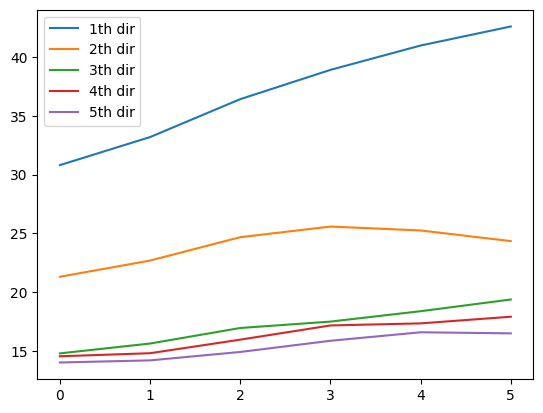

In [41]:
import matplotlib.pyplot as plt
top_k = 5
results = [[] for i in range(top_k)]
for r in result['svdrop']['mnistcifar'][0.9][0]['singular']:
    for i in range(top_k):
        results[i].append(r[i])

for i, r in enumerate(results):
    print(r)
    plt.plot(list(range(len(r))),r, label=f"{i+1}th dir")
    plt.legend()

In [91]:
result['svdrop_0.1']['mnistcifar'][0.9][0]['singular'][0].shape

torch.Size([1000])

In [30]:
result['svdrop']['mnistcifar'][0.9]

[{'train_acc': [0.49933332204818726,
   0.8162222504615784,
   0.5006666779518127,
   0.5054444670677185,
   0.633222222328186,
   0.7673333287239075],
  'train_loss': [0.6941957473754883,
   0.6771060228347778,
   0.6861786842346191,
   0.6867940425872803,
   0.6872900128364563,
   0.6871650218963623],
  'train_worst_group_loss': [0.7082667946815491,
   0.7202945351600647,
   0.7231586575508118,
   0.7193069458007812,
   0.7087821364402771,
   0.6991842985153198],
  'train_worst_group_acc': [0.0,
   0.0,
   0.0,
   0.0,
   0.01886792480945587,
   0.1603773534297943],
  'train_best_group_loss': [0.6792293190956116,
   0.660886824131012,
   0.6616171598434448,
   0.6663215756416321,
   0.6770252585411072,
   0.6843290328979492],
  'train_best_group_acc': [1.0,
   1.0,
   1.0,
   1.0,
   0.9813693761825562,
   0.8759925365447998],
  'ac_acc': [0.4959999918937683,
   0.38600000739097595,
   0.5040000081062317,
   0.5049999952316284,
   0.3970000147819519,
   0.3319999873638153],
  'ac_los

In [14]:
file_content['159_mnistcifar_0.9_True_222_svdrop']

{'singular': [tensor([32.9274, 22.3980, 15.4286, 14.9900, 14.2675, 13.8513, 12.3218, 11.5845,
          10.7855,  9.2560,  9.0577,  8.1294,  8.0367,  7.8205,  6.9247,  6.7964,
           6.7595,  6.6416,  6.4721,  6.4302,  6.1918,  6.1080,  5.9964,  5.7831,
           5.7444,  5.6793,  5.6025,  5.2733,  5.1143,  5.0652,  4.9473,  4.9210,
           4.8830,  4.7967,  4.6776,  4.5752,  4.4561,  4.4456,  4.3546,  4.3163,
           4.2124,  4.1624,  4.1349,  4.0350,  3.9734,  3.9233,  3.8568,  3.7934,
           3.7654,  3.7305,  3.6921,  3.6726,  3.6056,  3.5345,  3.4979,  3.4225,
           3.4095,  3.4059,  3.3421,  3.3059,  3.2773,  3.2394,  3.2240,  3.1998,
           3.1629,  3.1467,  3.1203,  3.0994,  3.0584,  3.0477,  2.9966,  2.9860,
           2.9683,  2.9275,  2.9019,  2.8884,  2.8618,  2.8497,  2.8144,  2.7914,
           2.7769,  2.7693,  2.7398,  2.7196,  2.7143,  2.6988,  2.6651,  2.6417,
           2.6236,  2.6049,  2.5813,  2.5661,  2.5405,  2.5224,  2.4935,  2.4780,
    

In [24]:
total = baselines._append(dfr)
total = total._append(svdrop)

In [39]:
total_pv = baselines.pivot(index='method',columns="spur",values=['val_acc',"val_worst_group_acc"])

In [44]:
total_pv[total_pv.index.isin(['erm',"erm_ft_100","erm_ft_1000",'rw',"gdro",'svdrop_0.1'])]

val_acc                                          \
spur           0.00    0.25    0.50    0.75    0.90    1.00   
method                                                        
erm          94.04%  93.69%  92.06%  88.48%  79.88%  59.20%   
erm_ft_100   92.11%  89.45%  90.31%  88.12%  86.30%  70.34%   
erm_ft_1000  92.24%  91.07%  90.59%  88.46%  87.10%  71.15%   
gdro         93.88%  93.55%  92.15%  88.45%  79.65%  54.45%   
rw           93.88%  93.19%  92.87%  90.84%  88.69%  59.49%   
svdrop_0.1   94.30%  94.53%  93.17%  89.90%  79.70%  69.00%   

            val_worst_group_acc                                          
spur                       0.00    0.25    0.50    0.75    0.90    1.00  
method                                                                   
erm                      93.24%  91.15%  86.16%  77.37%  58.75%  17.63%  
erm_ft_100               90.07%  86.49%  86.05%  79.94%  75.44%  57.90%  
erm_ft_1000              91.04%  88.87%  85.54%  79.88%  79.72%  62.73%  
gdro                     93.08%  90.60%  86.24%  77.60%  58.40%  31.25%  
rw                       93.22%  92.14%  90.54%  87.56%  84.82%  17.67%  
svdrop_0.1               93.60%  91.61%  87.87%  80.48%  64.62%  54.93%

In [32]:
total_pv.index

Index(['erm', 'erm_ft_10', 'erm_ft_100', 'erm_ft_1000', 'erm_ft_200',
       'erm_ft_50', 'erm_ft_500', 'gdro', 'imgnet_FT', 'rw', 'svdrop',
       'svdrop_0.0', 'svdrop_0.1', 'svdrop_0.2', 'svdrop_0.3', 'svdrop_0.4',
       'svdrop_0.5', 'svdrop_0.6', 'svdrop_0.7', 'svdrop_0.8', 'svdrop_0.9',
       'svdrop_1.0'],
      dtype='object', name='method')

In [41]:
total

method     dataset  spur val_acc val_worst_group_acc
0            rw  mnistcifar  0.00  93.51%              92.21%
1            rw  mnistcifar  0.25  92.67%              91.04%
2            rw  mnistcifar  0.50  92.39%              89.18%
3            rw  mnistcifar  0.75  90.38%              86.17%
4            rw  mnistcifar  0.90  88.25%              82.56%
5            rw  mnistcifar  1.00  58.19%               0.39%
6     imgnet_FT  mnistcifar  0.00  87.08%              85.19%
7     imgnet_FT  mnistcifar  0.25  85.69%              81.70%
8     imgnet_FT  mnistcifar  0.50  78.36%              72.46%
9     imgnet_FT  mnistcifar  0.75  66.89%              61.60%
10    imgnet_FT  mnistcifar  0.90  48.81%              44.67%
11    imgnet_FT  mnistcifar  1.00  47.92%              29.59%
12       svdrop  mnistcifar  0.00  93.00%              92.03%
13       svdrop  mnistcifar  0.25  73.07%              58.76%
14       svdrop  mnistcifar  0.50  72.13%              52.97%
15       svdrop  mnistcifar  0.75  68.47%              52.87%
16       svdrop  mnistcifar  0.90  66.77%              51.88%
17       svdrop  mnistcifar  1.00  62.23%              53.75%
18          erm  mnistcifar  0.00  93.57%              92.22%
19          erm  mnistcifar  0.25  93.37%              90.06%
20          erm  mnistcifar  0.50  91.67%              84.92%
21          erm  mnistcifar  0.75  88.10%              75.69%
22          erm  mnistcifar  0.90  79.44%              57.89%
23          erm  mnistcifar  1.00  56.87%               0.36%
24         gdro  mnistcifar  0.00  93.30%              92.38%
25         gdro  mnistcifar  0.25  92.98%              89.48%
26         gdro  mnistcifar  0.50  91.22%              84.47%
27         gdro  mnistcifar  0.75  87.73%              75.83%
28         gdro  mnistcifar  0.90  78.92%              56.50%
29         gdro  mnistcifar  1.00  51.40%               0.33%
0     erm_ft_10  mnistcifar  0.00  85.81%              72.75%
1     erm_ft_10  mnistcifar  0.25  82.96%              67.02%
2     erm_ft_10  mnistcifar  0.50  83.47%              63.52%
3     erm_ft_10  mnistcifar  0.75  81.32%              60.24%
4     erm_ft_10  mnistcifar  0.90  79.16%              58.91%
5     erm_ft_10  mnistcifar  1.00  64.91%              34.26%
6     erm_ft_50  mnistcifar  0.00  87.97%              79.54%
7     erm_ft_50  mnistcifar  0.25  88.56%              81.26%
8     erm_ft_50  mnistcifar  0.50  86.92%              73.14%
9     erm_ft_50  mnistcifar  0.75  85.23%              70.61%
10    erm_ft_50  mnistcifar  0.90  82.95%              63.59%
11    erm_ft_50  mnistcifar  1.00  69.13%              49.54%
12   erm_ft_100  mnistcifar  0.00  89.17%              84.67%
13   erm_ft_100  mnistcifar  0.25  87.37%              80.77%
14   erm_ft_100  mnistcifar  0.50  88.71%              80.30%
15   erm_ft_100  mnistcifar  0.75  85.15%              69.63%
16   erm_ft_100  mnistcifar  0.90  82.90%              61.48%
17   erm_ft_100  mnistcifar  1.00  68.91%              48.35%
18   erm_ft_200  mnistcifar  0.00  89.64%              86.51%
19   erm_ft_200  mnistcifar  0.25  88.71%              84.54%
20   erm_ft_200  mnistcifar  0.50  87.90%              79.55%
21   erm_ft_200  mnistcifar  0.75  84.52%              71.14%
22   erm_ft_200  mnistcifar  0.90  83.51%              67.58%
23   erm_ft_200  mnistcifar  1.00  68.66%              47.86%
24   erm_ft_500  mnistcifar  0.00  91.17%              89.26%
25   erm_ft_500  mnistcifar  0.25  89.76%              87.11%
26   erm_ft_500  mnistcifar  0.50  88.63%              81.18%
27   erm_ft_500  mnistcifar  0.75  87.71%              78.25%
28   erm_ft_500  mnistcifar  0.90  85.14%              73.12%
29   erm_ft_500  mnistcifar  1.00  70.11%              55.45%
30  erm_ft_1000  mnistcifar  0.00  91.32%              89.88%
31  erm_ft_1000  mnistcifar  0.25  90.37%              87.37%
32  erm_ft_1000  mnistcifar  0.50  89.60%              82.65%
33  erm_ft_1000  mnistcifar  0.75  86.20%

In [40]:
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)